# Group Project Report
Group 10: Deep Shah, Megan Ma, Can Okten, Kevin Cai

## Introduction

Bike sharing has become a widely adopted means of transportation in urban areas, with its usage varying based on several factors such as seasons, working days versus holidays, and temperature. The Bike Sharing Dataset available in the UCI Machine Learning Repository encompasses data from 2011 to 2012, detailing the hourly and daily counts of rental bikes in the Capital bike share system, along with corresponding weather and seasonal information. This dataset serves as a valuable resource for examining the impact of these factors on the demand for bike sharing.

Seasons play a significant role in bike sharing usage, as people tend to be more inclined to ride bikes during warmer months. Moreover, the distinction between working days and holidays can also influence bike sharing demand, as people's transportation needs differ on these occasions. Additionally, temperature emerges as a crucial factor affecting bike sharing usage; extreme heat or cold may deter people from opting for bikes.

In conclusion, the Bike Sharing Dataset provides essential insights into how seasons, working days versus holidays, and temperature can influence bike sharing demand. Analyzing this data enables us to gain a deeper understanding of the factors influencing bike sharing usage and offers valuable information for enhancing bike sharing systems to better cater to user needs.

## Methods and Results

First we install the packages we need to read, clean and wrangle, and plot our data.

In [28]:
library(tidyverse)
library(broom)
library(infer)

We uploaded the dataset from https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset to our project repository to read it from the web into R.

In [20]:
bike_day_data <- read_csv("https://raw.githubusercontent.com/megannma/stat-201-2023s2-group-10/main/day.csv")
head(bike_day_data)

Rows: 731 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (15): instant, season, yr, mnth, holiday, weekday, workingday, weathers...
date  (1): dteday

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.1604460,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.2485390,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.2483090,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.1602960,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.1869000,82,1518,1600
6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.0895652,88,1518,1606


Note that the seasons are displayed as numbers, where 1: Winter, 2: Spring, 3: Summer, 4: Fall. We clean and wrangle our data into a tidy format by only selecting the variables we need and converting their values into factors. Although the description for the dataset states that it does not have any missing values, we will demonstrate additional caution by filtering out any missing values.

In [21]:
selected_bike_day_data <-
    bike_day_data %>%
    select(season, workingday, temp, casual, registered, cnt) %>%
    mutate(season = as.factor(season), workingday = as.factor(workingday)) %>%
    filter(!is.na(season), !is.na(workingday), !is.na(temp), !is.na(casual), !is.na(registered), !is.na(cnt))
head(selected_bike_day_data)

season,workingday,temp,casual,registered,cnt
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0.344167,331,654,985
1,0,0.363478,131,670,801
1,1,0.196364,120,1229,1349
1,1,0.200000,108,1454,1562
1,1,0.226957,82,1518,1600
1,1,0.204348,88,1518,1606


Our first plot is a bar plot of the total number users for each season:

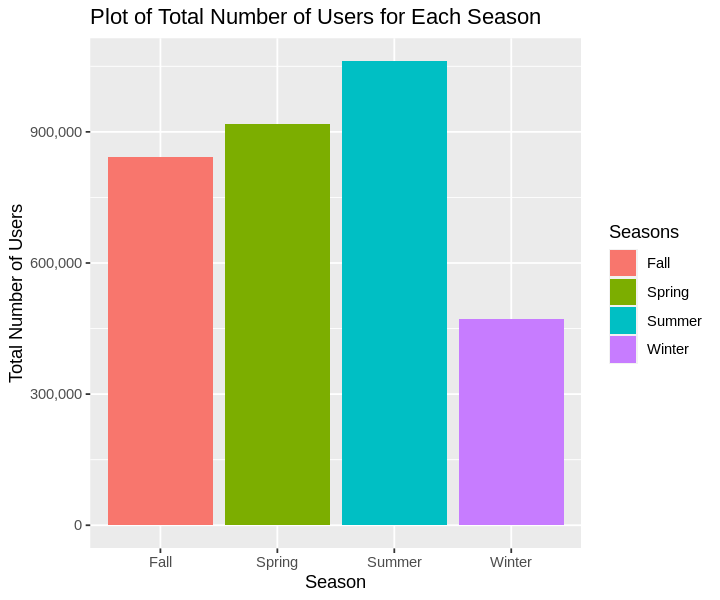

In [22]:
options(repr.plot.width = 6, repr.plot.height = 5)

season_plot <-
    selected_bike_day_data %>%
    group_by(season) %>%
    summarize(sum_cnt = sum(cnt)) %>%
    mutate(season = c("Winter", "Spring", "Summer", "Fall")) %>%
    ggplot(aes(x = season, y = sum_cnt, fill = season)) +
        geom_bar(stat = "identity") +
        labs(x = "Season", y = "Total Number of Users", fill = "Seasons") +
        scale_y_continuous(labels = scales::comma_format()) +
        ggtitle("Plot of Total Number of Users for Each Season")
season_plot

Our second plot is a bar plot of users on working days vs. non working days:

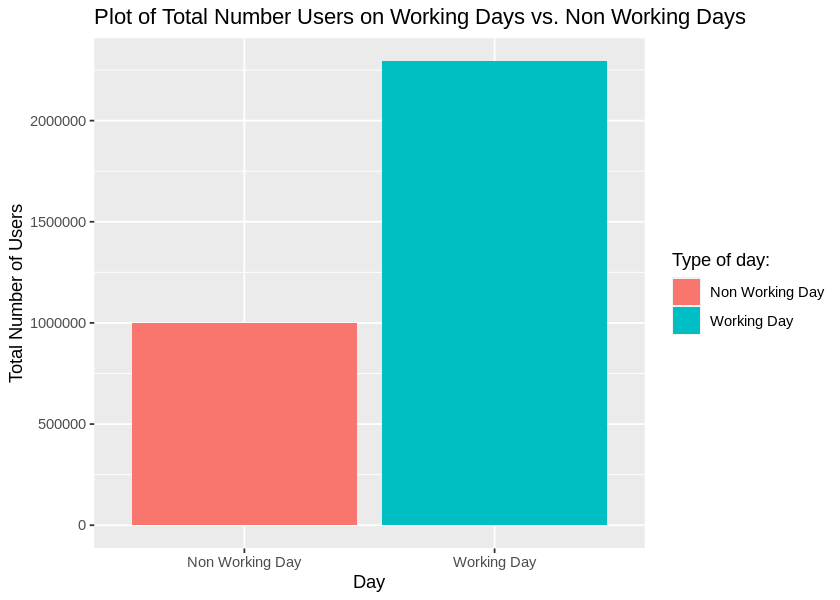

In [23]:
options(repr.plot.width = 7, repr.plot.height = 5)

workingday_plot <-
    selected_bike_day_data %>%
    group_by(workingday) %>%
    summarize(sum_cnt = sum(cnt)) %>%
    mutate(workingday = c("Non Working Day", "Working Day")) %>%
    ggplot(aes(x = workingday, y = sum_cnt, fill = workingday)) +
        geom_bar(stat = "identity") +
        labs(x = "Day", y = "Total Number of Users", fill = "Type of day:") +
        ggtitle("Plot of Total Number Users on Working Days vs. Non Working Days")

workingday_plot

Now we compute the estimates of our parameters: the mean active users for each season and the mean total users for working days vs. non working days.

In [24]:
# Compute the mean of active users for each season
season_means <-
    selected_bike_day_data %>%
    group_by(season) %>%
    summarize(mean = mean(cnt)) %>%
    mutate(season = c("Winter", "Spring", "Summer", "Fall"))

# Compute the mean total users for working days vs. non working days
days_means <-
    selected_bike_day_data %>%
    group_by(workingday) %>%
    summarize(mean = mean(cnt)) %>%
    mutate(workingday = c("Non Working Day", "Working Day"))

season_means
days_means

season,mean
<chr>,<dbl>
Winter,2604.133
Spring,4992.332
Summer,5644.303
Fall,4728.163


workingday,mean
<chr>,<dbl>
Non Working Day,4330.169
Working Day,4584.820


Although we indicated in the "Methods: Plan" section of our proposal that we were interested in the difference in proportions for the number of users in the summer and the number of users in the winter, we decided instead to analyze the difference in means. We realized that since the number of users is quantitative, it would be more reasonable to use the difference in means as our parameter instead. Our chosen significance level is 0.05 and our confidence level is 95% because these levels are commonly used as convention. In order to compare the bootstrapping and asymptotics methods, we will perform our analysis with both methods.

Our null and alternative hypotheses, denoted $H_0$ and $H_A$ respectively, are as follows:

$H_0: \mu_S = \mu_W$ vs $H_A: \mu_S \neq \mu_W$

where $\mu_S$ is the mean number of users in the summer and $\mu_W$ is the mean number of users in the winter. In other words, our null hypothesis is the mean number of bike sharing users is the same in the summer and in the winter, and our alternative hypothesis is the mean number of bike sharing users is not the same in the summer and in the winter.

First, we use the bootstrapping method to obtain a p-value and a 95% confidence interval. We will set the seed to 1 to ensure our analysis is reproducible.

In [25]:
# Set seed
set.seed(1)

# Filter the data so it only contains observations for the summer and winter seasons
filtered_data <- selected_bike_day_data %>%
    filter(season == 1 | season == 3)

# Obtain the null distribution
null_distribution <- filtered_data %>%
    specify(formula = cnt ~ season) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 1000, type = "permute") %>%
    calculate(stat = "diff in means", order = c(3, 1))

# Compute the observed difference in means
obs_diff_means <- filtered_data %>%
    specify(formula = cnt ~ season) %>%
    calculate(stat = "diff in means", order = c(3, 1))

# Compute the p-value from the null distribution
p_value <- null_distribution %>%
    get_p_value(obs_stat = obs_diff_means, direction = "both")

# Obtain a bootstrap distribution
bootstrap_distribution <- filtered_data %>%
    specify(formula = cnt ~ season) %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "diff in means", order = c(3, 1))

# Construct a 95% confidence interval for the true difference in means
percentile_ci <- bootstrap_distribution %>%
    get_confidence_interval(level = 0.95, type = "percentile")

# Display the results
tibble(obs_diff_means, p_value, percentile_ci)

Dropping unused factor levels c("2", "4") from the supplied explanatory variable 'season'.

Dropping unused factor levels c("2", "4") from the supplied explanatory variable 'season'.

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”
Dropping unused factor levels c("2", "4") from the supplied explanatory variable 'season'.



stat,p_value,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
3040.171,0,2766.804,3341.342


Now we can visualize the p-value and confidence interval with our null distribution and bootstrap distribution:

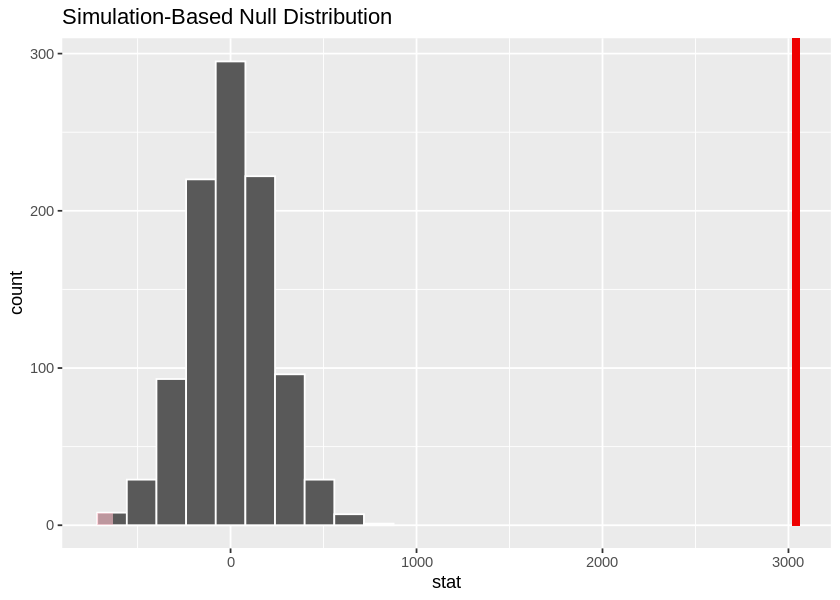

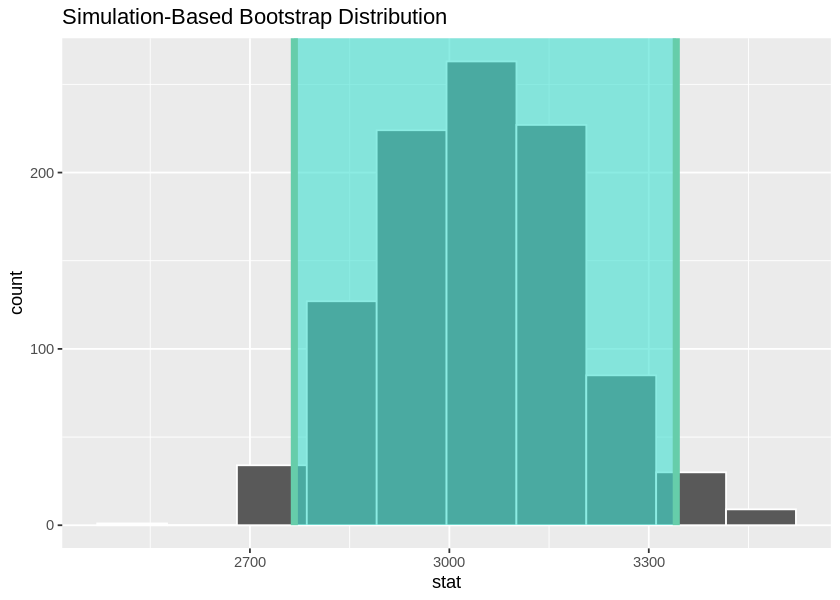

In [26]:
visualize(null_distribution, bins = 10) +
    shade_p_value(obs_stat = obs_diff_means, direction = "both")
visualize(bootstrap_distribution, bins = 10) +
    shade_confidence_interval(endpoints = percentile_ci)

From our analysis using a simulation-based null distribution, we obtained a p-value of 0. This p-value is significantly lower than our significance level of 0.05, so we reject the null hypothesis and conclude that there is a significant difference in the mean users in the summer and the mean users in the winter. From bootstrapping, we also obtain a confidence interval of (2766.804, 3341.342). Thus, we are 95% "confident" that the true difference in the mean users in the summer and the mean users in the winter is between 2766.804 and 3341.342. The observed difference in means for our dataset is 3040.171, which is captured by this confidence interval. However, 0 is not captured, so we can consider that the true difference in means is not 0.

Second, we use the two-sample t-test to obtain a p-value and a 95% confidence interval. To explore the differences between doing the whole hypothesis test ourselves and doing it fully in R, we will compute the necessary statistics ourselves to use for a two-sample t-test and then compare it with the output of the `t.test` function.

In [27]:
# Create two data frames for summer and winter counts
summer_cnt <- filtered_data %>%
    filter(season == 3) %>%
    select(cnt)
winter_cnt <- filtered_data %>%
    filter(season == 1) %>%
    select(cnt)

# Compute the number of observations for summer and winter
summer_n <- nrow(summer_cnt)
winter_n <- nrow(winter_cnt)

# Compute the mean counts for summer and winter
summer_mean <- mean(summer_cnt$cnt)
winter_mean <- mean(winter_cnt$cnt)

# Compute the standard deviation of counts for summer and winter
summer_sd <- sd(summer_cnt$cnt)
winter_sd <- sd(winter_cnt$cnt)

# Compute the difference in means between summer counts and winter counts
mean_diff <- summer_mean - winter_mean

# Compute the standard error under the null distribution
null_std_error <- sqrt(summer_sd^2/summer_n+winter_sd^2/winter_n)

# Compute the degrees of freedom
df <- (summer_sd^2/summer_n+winter_sd^2/winter_n)^2 / (summer_sd^4/(summer_n^2*(summer_n-1))+winter_sd^4/(winter_n^2*(winter_n-1)))

# Compute the p-value
p_value <- pt(mean_diff, df = df, lower.tail = FALSE)

# Construct a 95% confidence interval for the true population parameter
ci <- tibble(lower_ci = mean_diff - qt(0.975, df = df) * null_std_error,
             upper_ci = mean_diff + qt(0.975, df = df) * null_std_error)

# Display the results in a tibble
tibble(mean_diff, p_value, ci)

# Perform the two-sample t-test again using the R function `t.test`
seasons_t_test <- tidy(t.test(x = summer_cnt$cnt, y = winter_cnt$cnt, alternative = "two.sided"))
seasons_t_test

mean_diff,p_value,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
3040.171,0,2747.42,3332.921


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
3040.171,5644.303,2604.133,20.4213,1.827511e-62,366.9946,2747.42,3332.921,Welch Two Sample t-test,two.sided


From our analysis using the asymptotics method, we obtained a p-value of 0. The p_value we obtained from using the `t.test` function is 1.827511e-62, which is nearly 0. This p-value is significantly lower than our significance level of 0.05, so we reject the null hypothesis and conclude that there is a significant difference in the mean users in the summer and the mean users in the winter. We also obtain a confidence interval of (2747.42, 3332.921). Thus, we are 95% "confident" that the true difference in the mean users in the summer and the mean users in the winter is between 2747.42 and 3332.921. The observed difference in means for our dataset is 3040.171, which is captured by this confidence interval. However, 0 is not captured, so we can consider that the true difference in means is not 0.

## Discussion

## References
1. El-Assi, W., Salah Mahmoud, M. & Nurul Habib, K. Effects of built environment and weather on bike sharing demand: a station level analysis of commercial bike sharing in Toronto. Transportation 44, 589–613 (2017). https://doi.org/10.1007/s11116-015-9669-z
2. UCI Machine Learning Repository: Bike Sharing Dataset. https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset